In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from IPython.display import display

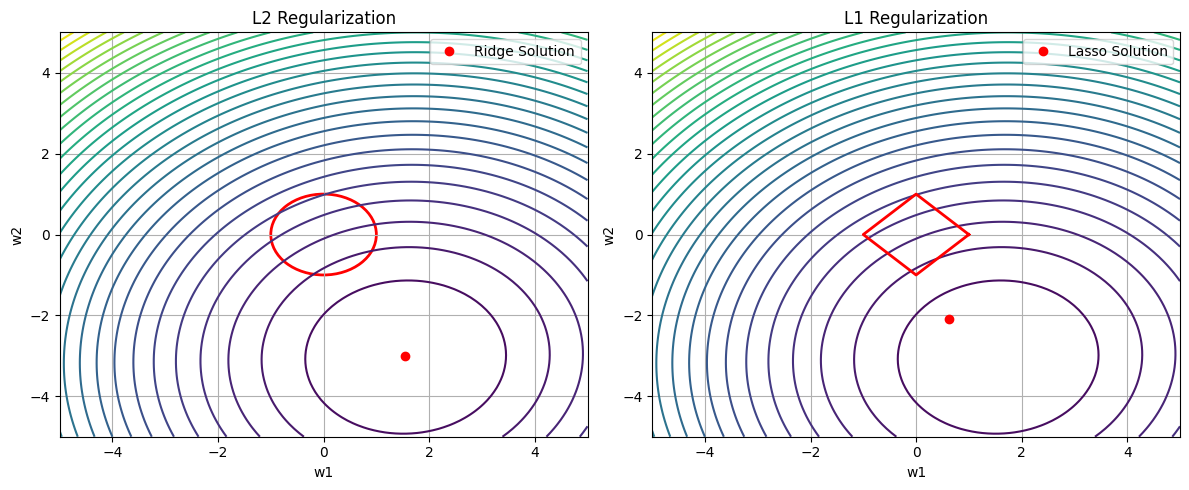

In [3]:
# 1. L1/L2正則化の可視化 (2次元の重み空間)
np.random.seed(0)

# 特徴量2次元のデータ生成
X_2d = np.random.randn(100, 2)
true_coef_2d = np.array([1.5, -3.0])
y_2d = X_2d @ true_coef_2d + np.random.randn(100) * 0.5

# Lasso(L1)とRidge(L2)モデルを学習
alpha = 1.0
lasso_2d = Lasso(alpha=alpha).fit(X_2d, y_2d)
ridge_2d = Ridge(alpha=alpha).fit(X_2d, y_2d)

# グリッド(w1, w2)上の損失を計算
w1 = np.linspace(-5, 5, 100)
w2 = np.linspace(-5, 5, 100)
W1, W2 = np.meshgrid(w1, w2)
loss = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([W1[i, j], W2[i, j]])
        loss[i, j] = np.mean((y_2d - X_2d @ w) ** 2)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# L2正則化 (円)
axes[0].contour(W1, W2, loss, levels=30, cmap='viridis')
circle = plt.Circle((0, 0), np.sqrt(alpha), color='red', fill=False, linewidth=2)
axes[0].add_patch(circle)
axes[0].plot(ridge_2d.coef_[0], ridge_2d.coef_[1], 'ro', label='Ridge Solution')
axes[0].set_title('L2 Regularization')
axes[0].set_xlabel('w1')
axes[0].set_ylabel('w2')
axes[0].legend()
axes[0].grid(True)

# L1正則化 (菱形)
axes[1].contour(W1, W2, loss, levels=30, cmap='viridis')
diamond = np.array([[alpha, 0], [0, alpha], [-alpha, 0], [0, -alpha], [alpha, 0]])
axes[1].plot(diamond[:, 0], diamond[:, 1], 'r-', linewidth=2)
axes[1].plot(lasso_2d.coef_[0], lasso_2d.coef_[1], 'ro', label='Lasso Solution')
axes[1].set_title('L1 Regularization')
axes[1].set_xlabel('w1')
axes[1].set_ylabel('w2')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Original Coefficient,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
L1 Regularized,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00
L2 Regularized,0.06,-0.40,-0.01,-0.10,0.42,0.16,0.28,-0.10,-0.37,0.05,...,-0.21,-0.42,0.01,0.14,-0.10,-0.21,-0.50,0.08,0.02,0.21


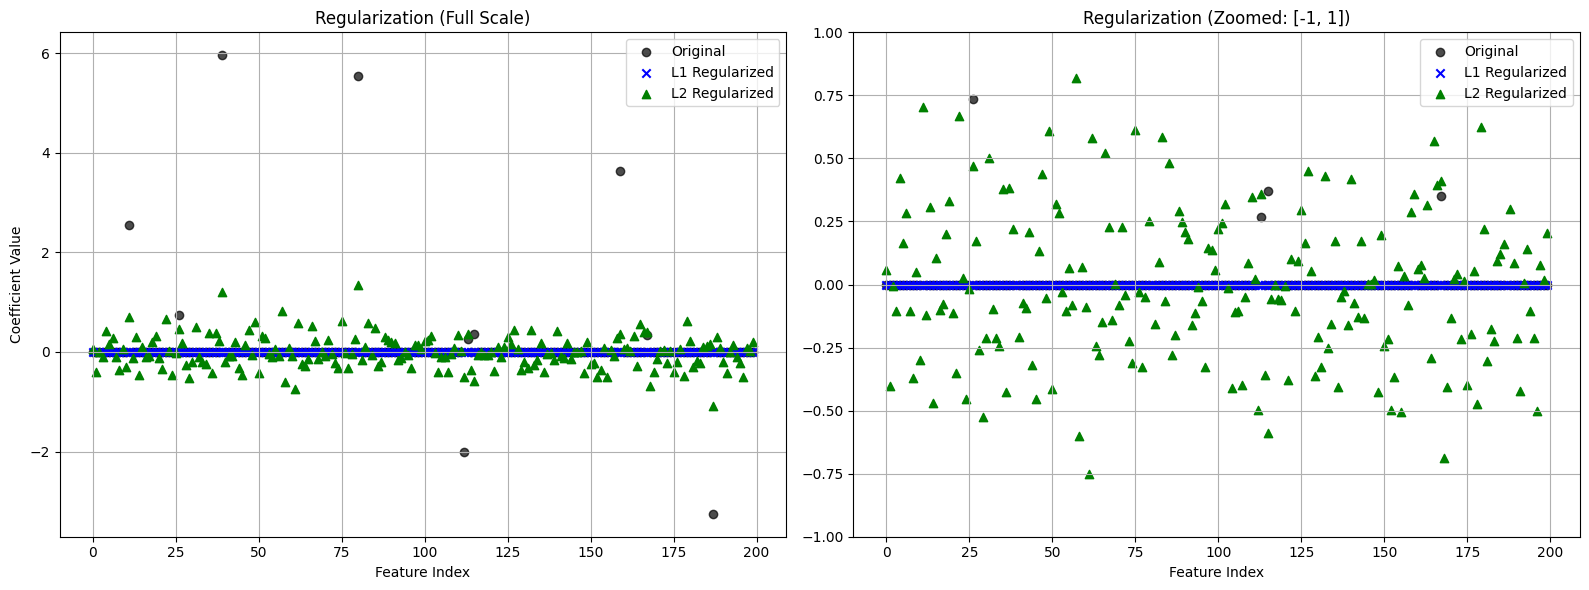

In [4]:
# 2. 200次元でのL1/L2正則化の比較
np.random.seed(42)

# データ生成 (特徴量200、サンプル50)
n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)

# 係数をスパース化 (10個だけ非ゼロに)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0

# ターゲット生成 (ノイズあり)
y = np.dot(X, coef) + 0.01 * np.random.randn(n_samples)

# L1/L2正則化モデルを学習
alpha_hd = 0.1 * n_samples
lasso_model = Lasso(alpha=alpha_hd, max_iter=30000).fit(X, y)
ridge_model = Ridge(alpha=alpha_hd).fit(X, y)
l1_coef = lasso_model.coef_
l2_coef = ridge_model.coef_

# 正則化前後の係数をDataFrameにまとめる
df = pd.DataFrame({
    'Original Coefficient': coef,
    'L1 Regularized': l1_coef,
    'L2 Regularized': l2_coef
})

# 表示用に小数第2位へ丸めて転置
df_display = df.copy().T.apply(lambda col: col.map(lambda x: f"{x:.2f}"))
display(df_display)

# 散布図：正則化前後の係数を比較 (通常スケール & ズーム表示)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
x = np.arange(n_features)

# 通常スケール
axes[0].scatter(x, df['Original Coefficient'], label='Original', color='black', marker='o', alpha=0.7)
axes[0].scatter(x, df['L1 Regularized'], label='L1 Regularized', color='blue', marker='x')
axes[0].scatter(x, df['L2 Regularized'], label='L2 Regularized', color='green', marker='^')
axes[0].set_title('Regularization (Full Scale)')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Coefficient Value')
axes[0].legend()
axes[0].grid(True)

# ズームスケール（小さな差異を拡大）
axes[1].scatter(x, df['Original Coefficient'], label='Original', color='black', marker='o', alpha=0.7)
axes[1].scatter(x, df['L1 Regularized'], label='L1 Regularized', color='blue', marker='x')
axes[1].scatter(x, df['L2 Regularized'], label='L2 Regularized', color='green', marker='^')
axes[1].set_title('Regularization (Zoomed: [-1, 1])')
axes[1].set_xlabel('Feature Index')
axes[1].set_ylim(-1, 1)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()